In [9]:
import pandas
import numpy as np
from sklearn.model_selection import train_test_split
import graphing # custom graphing code. See our GitHub repo for details

# Import the data from the .csv file
dataset = pandas.read_csv('sf_crime.csv', delimiter="\t")

# Remember to one-hot encode our crime and PdDistrict variables 
categorical_features = ["Category", "PdDistrict"]
dataset = pandas.get_dummies(dataset, columns=categorical_features, drop_first=False)

# Split the dataset in an 90/10 train/test ratio. 
# Recall that our dataset is very large so we can afford to do this
# with only 10% entering the test set
train, test = train_test_split(dataset, test_size=0.1, random_state=2, shuffle=True)

# Let's have a look at the data and the relationship we are going to model
print(dataset.head())
print("train shape:", train.shape)
print("test shape:", test.shape)

   DayOfWeek  Resolution           X          Y  day_of_year  time_in_hours  \
0          5        True -122.403405  37.775421           29      11.000000   
1          5        True -122.403405  37.775421           29      11.000000   
2          1        True -122.388856  37.729981          116      14.983333   
3          2       False -122.412971  37.785788            5      23.833333   
4          5       False -122.419672  37.765050            1       0.500000   

   Category_ARSON  Category_ASSAULT  Category_BAD CHECKS  Category_BRIBERY  \
0               0                 0                    0                 0   
1               0                 0                    0                 0   
2               0                 0                    0                 0   
3               0                 0                    0                 0   
4               0                 0                    0                 0   

   ...  PdDistrict_BAYVIEW  PdDistrict_CENTRAL  PdDistri

In [10]:
from sklearn.metrics import balanced_accuracy_score

# Make a utility method that we can re-use throughout this exercise
# To easily fit and test out model

features = [c for c in dataset.columns if c != "Resolution"]

def fit_and_test_model(model):
    '''
    Trains a model and tests it against both train and test sets
    '''  
    global features

    # Train the model
    model.fit(train[features], train.Resolution)

    # Assess its performance
    # -- Train
    predictions = model.predict(train[features])
    train_accuracy = balanced_accuracy_score(train.Resolution, predictions)

    # -- Test
    predictions = model.predict(test[features])
    test_accuracy = balanced_accuracy_score(test.Resolution, predictions)

    return train_accuracy, test_accuracy


print("Ready to go!")

Ready to go!


In [11]:
import sklearn.tree
# re-fit our last decision tree to print out its performance
model = sklearn.tree.DecisionTreeClassifier(random_state=1, max_depth=10) 

dt_train_accuracy, dt_test_accuracy = fit_and_test_model(model)

print("Decision Tree Performance:")
print("Train accuracy", dt_train_accuracy)
print("Test accuracy", dt_test_accuracy)

Decision Tree Performance:
Train accuracy 0.7742407145595661
Test accuracy 0.7597105242913844


## Random Forest

A random forest is a collection of decision trees that work together to calculate the label for a sample.

Trees in a random forest are trained independently, on different partitions of data, and thus develop different biases, but when combined they are less likely to overfit the data.

Let's build a very simple forest with two trees and the *default* parameters:

In [12]:
from sklearn.ensemble import RandomForestClassifier

# Create a random forest model with two trees
random_forest = RandomForestClassifier( n_estimators=2,
                                        random_state=2,
                                        verbose=False)

# Train and test the model
train_accuracy, test_accuracy = fit_and_test_model(random_forest)
print("Random Forest Performance:")
print("Train accuracy", train_accuracy)
print("Test accuracy", test_accuracy)

Random Forest Performance:
Train accuracy 0.8842998107846062
Test accuracy 0.734378540999183


Our two-tree forest has done more poorly than the single tree on the test set, though has done a better job on the train set. 

To some extent this should be expected. Random forests usually work with many more trees. Simply having two allowed it to overfit the training data much better than the original decision tree.

## Altering the number of trees

Let's then build several forest models, each with a different number of trees, and see how they perform:

Preparing a model with 2 trees...
Preparing a model with 5 trees...
Preparing a model with 10 trees...
Preparing a model with 20 trees...
Preparing a model with 50 trees...


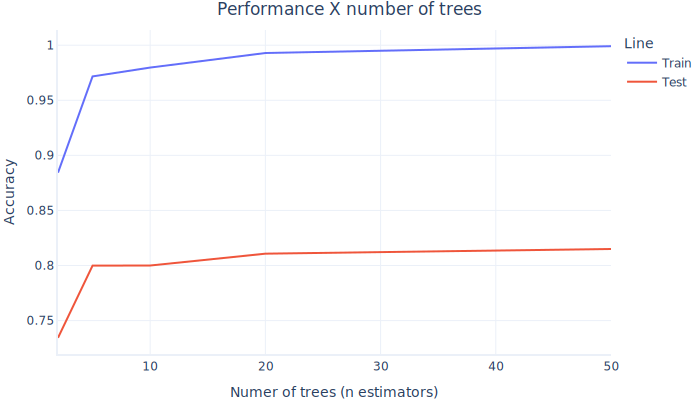

In [13]:
import plotly.io as pio
pio.renderers.default = "svg"

# n_estimators states how many trees to put in the model
# We will make one model for every entry in this list
# and see how well each model performs 
n_estimators = [2, 5, 10, 20, 50]

# Train our models and report their performance
train_accuracies = []
test_accuracies = []

for n_estimator in n_estimators:
    print("Preparing a model with", n_estimator, "trees...")

    # Prepare the model 
    rf = RandomForestClassifier(n_estimators=n_estimator, 
                                random_state=2, 
                                verbose=False)
    
    # Train and test the result
    train_accuracy, test_accuracy = fit_and_test_model(rf)

    # Save the results
    test_accuracies.append(test_accuracy)
    train_accuracies.append(train_accuracy)


# Plot results
graphing.line_2D(dict(Train=train_accuracies, Test=test_accuracies), 
                    n_estimators,
                    label_x="Numer of trees (n_estimators)",
                    label_y="Accuracy",
                    title="Performance X number of trees")

The metrics look great for the *training* set, but not so much for the *test* set. More trees tended to help both but only up to a point.

We might have expected the number of trees to resolve our overfitting problem, but this was not the case! Chances are that the model is simply too complex relative to the data, allowing it to overfit the training set.

## Altering the minimum number of samples for split parameter

Recall that decision trees have a *root node*, *internal nodes* and *leaf nodes*, and that the first two can be split into newer nodes with subsets of data.

If we let our model split and create too many nodes, it can become increasingly complex and start to overfit.

One way to limit that complexity is to tell the model that each node needs to have __at least__ a certain number of samples, otherwise it can't split into subnodes. 

In other words, we can set the model's `min_samples_split` parameter to the least number of samples required so that a node can be split.

Our default value for `min_samples_split` is only `2`, so models will quickly become too complex if that parameter is left untouched.

We will now use the best performing model above, then try it with different `min_samples_split` values and compare the results:

Preparing a model with min_samples_split =  2
Preparing a model with min_samples_split =  10
Preparing a model with min_samples_split =  20
Preparing a model with min_samples_split =  50
Preparing a model with min_samples_split =  100
Preparing a model with min_samples_split =  500


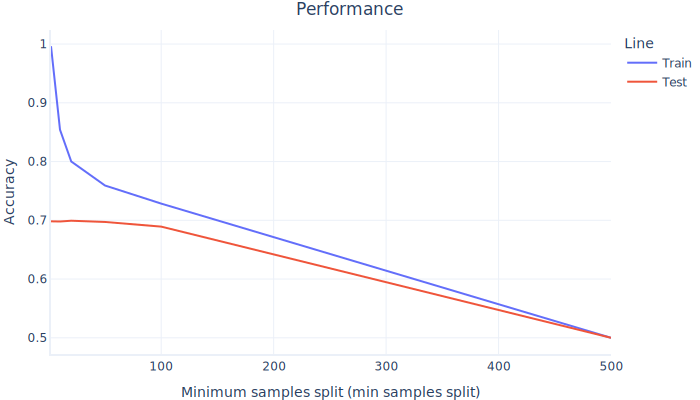

In [14]:
# Shrink the training set temporarily to explore this
# setting with a more normal sample size
full_trainset = train
train = full_trainset[:1000] # limit to 1000 samples

min_samples_split = [2, 10, 20, 50, 100, 500]

# Train our models and report their performance
train_accuracies = []
test_accuracies = []

for min_samples in min_samples_split:
    print("Preparing a model with min_samples_split = ", min_samples)

    # Prepare the model 
    rf = RandomForestClassifier(n_estimators=20,
                                min_samples_split=min_samples,
                                random_state=2, 
                                verbose=False)
    
    # Train and test the result
    train_accuracy, test_accuracy = fit_and_test_model(rf)

    # Save the results
    test_accuracies.append(test_accuracy)
    train_accuracies.append(train_accuracy)


# Plot results
graphing.line_2D(dict(Train=train_accuracies, Test=test_accuracies), 
                    min_samples_split,
                    label_x="Minimum samples split (min_samples_split)",
                    label_y="Accuracy",
                    title="Performance", show=True)

# Rol back the trainset to the full set
train = full_trainset

As you can see above, small restrictions on the model's complexity - by limiting its ability to split nodes - reduce the gap between training and test performance. If this is subtle, it does so without damaging test performance at all.

By limiting the model complexity we address `overfitting`, improving its ability to generalize and make accurate predictions on *unseen* data.

Notice that using `min_samples_split=20` gave us the best result for the *test* set, and that higher values worsened outcomes.

## Altering the model depth

A related method to limit the trees is restricting `max_depth`. This is equivalent to `max_depth` we used for our decision tree, earlier. Its default value is `None`, which means nodes can be expanded until all leaves are *pure* (all samples in it have the same label) or have less samples than the value set for `min_samples_split`.

Whether `max_depth`, or `min_samples_split` is more appropriate depends on the nature of your dataset, including its size. Usually we need to experiment to find the best settings. Let's investigate `max_depth` as though we only had 500 crime samples available for our training set.

In [15]:
# Shrink the training set temporarily to explore this
# setting with a more normal sample size
full_trainset = train
train = full_trainset[:500] # limit to 500 samples

max_depths = [2, 4, 6, 8, 10, 15, 20, 50, 100]

# Train our models and report their performance
train_accuracies = []
test_accuracies = []

for max_depth in max_depths:
    print("Preparing a model with max_depth = ", max_depth)

    # Prepare the model 
    rf = RandomForestClassifier(n_estimators=20,
                                max_depth=max_depth,
                                random_state=2, 
                                verbose=False)
    
    # Train and test the result
    train_accuracy, test_accuracy = fit_and_test_model(rf)

    # Save the results
    test_accuracies.append(test_accuracy)
    train_accuracies.append(train_accuracy)


# Plot results
graphing.line_2D(dict(Train=train_accuracies, Test=test_accuracies),
                    max_depths,
                    label_x="Maximum depth (max_depths)",
                    label_y="Accuracy",
                    title="Performance")

# Rol back the trainset to the full set
train = full_trainset

Preparing a model with max_depth =  2
Preparing a model with max_depth =  4
Preparing a model with max_depth =  6
Preparing a model with max_depth =  8
Preparing a model with max_depth =  10
Preparing a model with max_depth =  15
Preparing a model with max_depth =  20
Preparing a model with max_depth =  50
Preparing a model with max_depth =  100


The plot above tells us that our model actually __benefits__ from a higher value for `max_depth`, up to the limit of `15`.

Increasing depth beyond this point begins to harm test performence, as it constrains the model too much for it to generalize.

As usual, it is important to evaluate different values when setting model parameters and defining its architecture.

## An optimised model

Properly optimizing a model on a dataset this large can take many hours - more than you need to commit to this exercise just to learn. If you would like to run a model that has already been optimized for the full dataset, you can run the code below, and compare its performance to everything we have seen so far.

This is optional - just note that the model may take 1 - 2 minutes to train due to its size and the sheer volume of data

In [16]:
# Prepare the model 
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=128,
                            max_features=25,
                            min_samples_split=2,
                            random_state=2, 
                            verbose=False)

# Train and test the result
print("Training model. This may take 1 - 2 minutes")
train_accuracy, test_accuracy = fit_and_test_model(rf)

# Print out results, compared to the decision tree
data = {"Model": ["Decision tree","Final random forest"],
        "Train sensitivity": [dt_train_accuracy, train_accuracy],
        "Test sensitivity": [dt_test_accuracy, test_accuracy]
        }

pandas.DataFrame(data, columns = ["Model", "Train sensitivity", "Test sensitivity"])

Training model. This may take 1 - 2 minutes


,Model,Train sensitivity,Test sensitivity
0,Decision tree,0.774241,0.759711
1,Final random forest,0.999657,0.816087



As you can see, fine tuning the model's parameters resulted in a significant improvement in the test set results.